# Test if we are able to reproduce spherical harmonics

In [4]:
import numpy as np

from pydiffmap import diffusion_map as dm
from scipy.sparse import csr_matrix

np.random.seed(100)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## generate data on a Sphere

In [100]:
m = 10000
Phi = 2*np.pi*np.random.rand(m) - np.pi
Theta = np.pi*np.random.rand(m) - 0.5*np.pi
X = np.cos(Theta)*np.cos(Phi)
Y = np.cos(Theta)*np.sin(Phi)
Z = np.sin(Theta)
data = np.array([X, Y, Z]).transpose()



## run diffusion maps

In [121]:
eps = 0.01
mydmap = dm.DiffusionMap(n_evecs=4, epsilon=eps, alpha=1.0, k=400)
mydmap.fit_transform(data)
test_evals = -4./eps*(mydmap.evals - 1)
print(test_evals)

[ 1.86799738  1.89100929  1.90225133  5.54375136]


The true eigenfunctions here are spherical harmonics $Y_l^m(\theta, \phi)$ and the true eigenvalues are $\lambda_l = l(l+1)$. The eigenfunction corresponding to $l=0$ is the constant function, which we ommit. Since $l=1$ has multiplicity three, this gives the benchmark eigenvalues [2, 2, 2, 6].

In [122]:
real_evals = np.array([2, 2, 2, 6])
eval_error = np.abs(test_evals-real_evals)/real_evals
print(eval_error)

[ 0.06600131  0.05449536  0.04887434  0.07604144]


## visualisation

We check that we get the correct embedding (which is again a sphere). We also visualize the eigenfunctions.

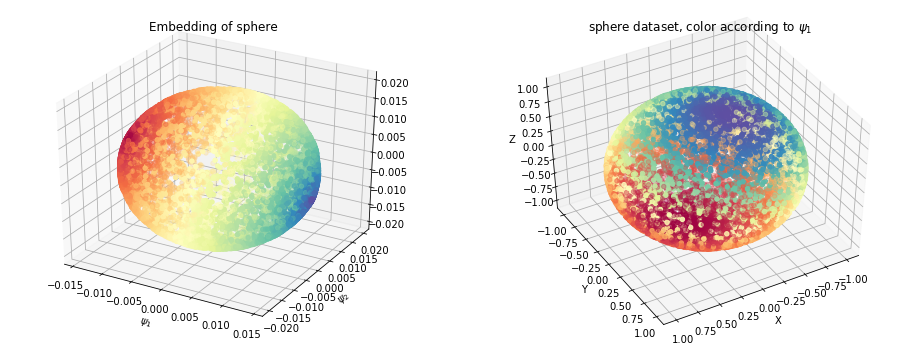

In [120]:
plt.figure(figsize=(16,6))
ax = plt.subplot(121, projection='3d')
ax.scatter(mydmap.dmap[:,0],mydmap.dmap[:,1], mydmap.dmap[:,2], c=Theta, cmap=plt.cm.Spectral)
ax.set_title('Embedding of sphere')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.axis('tight')

ax2 = plt.subplot(122,projection='3d')
ax2.scatter(X,Y,Z, c=mydmap.dmap[:,0], cmap=plt.cm.Spectral)
ax2.view_init(45, 60)
ax2.set_title('sphere dataset, color according to $\psi_1$')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

## Rotating the dataset

There is rotational symmetry in this dataset. To remove it, we define the 'north pole' to be the point where the first diffusion coordinate attains its maximum value.

In [123]:
northpole = np.argmax(mydmap.dmap[:,0])
north = data[northpole,:]
phi_n = Phi[northpole]
theta_n = Theta[northpole]
R = np.array([[np.sin(theta_n)*np.cos(phi_n), np.sin(theta_n)*np.sin(phi_n), -np.cos(theta_n)],
              [-np.sin(phi_n), np.cos(phi_n), 0],
             [np.cos(theta_n)*np.cos(phi_n), np.cos(theta_n)*np.sin(phi_n), np.sin(theta_n)]])

In [124]:
data_rotated = np.dot(R,data.transpose())
data_rotated.shape

(3, 10000)

Now that the dataset is rotated, we can check how well the first diffusion coordinate approximates the first spherical harmonic $Y_1^1(\theta, \phi) = \sin(\theta) = Z$.

Correlation between \phi and \psi_1
[[ 1.          0.99984053]
 [ 0.99984053  1.        ]]


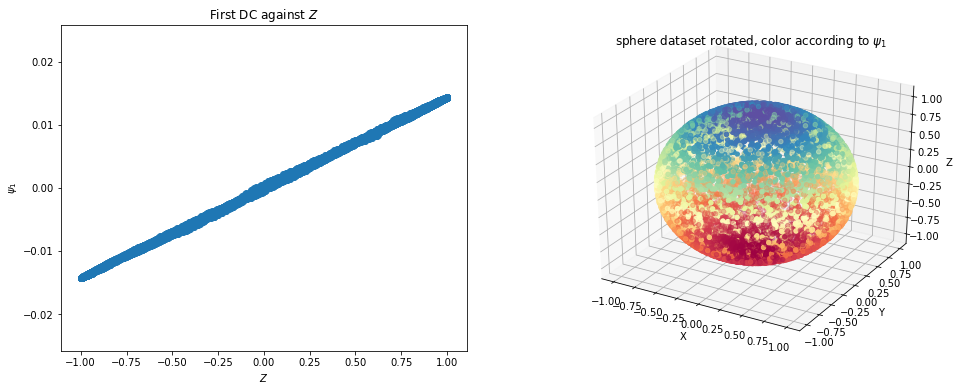

In [128]:
print('Correlation between \phi and \psi_1')
print(np.corrcoef(mydmap.dmap[:,0], data_rotated[2,:]))

plt.figure(figsize=(16,6))
ax = plt.subplot(121)
ax.scatter(data_rotated[2,:], mydmap.dmap[:,0])
ax.set_title('First DC against $Z$')
ax.set_xlabel(r'$Z$')
ax.set_ylabel(r'$\psi_1$')
ax.axis('tight')

ax2 = plt.subplot(122,projection='3d')
ax2.scatter(data_rotated[0,:],data_rotated[1,:],data_rotated[2,:], c=mydmap.dmap[:,0], cmap=plt.cm.Spectral)
#ax2.view_init(75, 10)
ax2.set_title('sphere dataset rotated, color according to $\psi_1$')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()